2. Matrices de Confusión por Tarea:
    - Visualizar matrices de confusión para las tareas de partes, daños y sugerencias, para identificar patrones de error y clases confundidas.

In [1]:
# Importar librerías necesarias
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

2025-05-14 11:34:01.651918: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 11:34:01.652607: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 11:34:01.656753: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 11:34:01.668690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747236841.688843   81799 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747236841.69

In [2]:
# =============================================
# DICCIONARIOS DE MAPEO
# =============================================
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

In [3]:
# =============================================
# CONFIGURACIÓN
# =============================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 30  # Entrenamiento inicial con base congelada
EPOCHS_FINE_TUNE = 30  # Entrenamiento con ajuste fino
LEARNING_RATE_INITIAL = 5e-5  # Ajuste de tasa de aprendizaje inicial
LEARNING_RATE_FINE_TUNE = 5e-6  # Ajuste de tasa de aprendizaje para fine-tuning
BASE_MODEL = 'EfficientNetB0'

In [4]:
# =============================================
# CARGA DE DATOS
# =============================================
def load_and_prepare_data(split_dir):
    """Carga imágenes y etiquetas para un conjunto (train/val/test)"""
    df = pd.read_csv(f'{split_dir}/{split_dir.split("/")[-1]}_set.csv', sep='|')
    # Convertir strings de listas a listas reales
    for col in ['dannos', 'partes', 'sugerencias']:
        df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    return df

# Cargar todos los conjuntos
train_df = load_and_prepare_data('data/fotos_siniestros/train')
val_df = load_and_prepare_data('data/fotos_siniestros/val')
test_df = load_and_prepare_data('data/fotos_siniestros/test')

In [5]:
# =============================================
# PREPARACIÓN DE ETIQUETAS
# =============================================
mlb_partes = MultiLabelBinarizer()
mlb_dannos = MultiLabelBinarizer()
mlb_sugerencias = MultiLabelBinarizer()

y_train_partes = mlb_partes.fit_transform(train_df['partes'])
y_train_dannos = mlb_dannos.fit_transform(train_df['dannos'])
y_train_sugerencias = mlb_sugerencias.fit_transform(train_df['sugerencias'])

y_val_partes = mlb_partes.transform(val_df['partes'])
y_val_dannos = mlb_dannos.transform(val_df['dannos'])
y_val_sugerencias = mlb_sugerencias.transform(val_df['sugerencias'])

# Guardar MultiLabelBinarizer objects para uso posterior
import pickle
with open("mlb_partes.pkl", "wb") as f:
    pickle.dump(mlb_partes, f)
with open("mlb_dannos.pkl", "wb") as f:
    pickle.dump(mlb_dannos, f)
with open("mlb_sugerencias.pkl", "wb") as f:
    pickle.dump(mlb_sugerencias, f)
print("MultiLabelBinarizer objects saved.")

MultiLabelBinarizer objects saved.


In [6]:
# =============================================
# GENERADOR DE DATOS
# =============================================
class MultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mlb_partes, mlb_dannos, mlb_sugerencias, 
                 batch_size=32, img_size=(224, 224), shuffle=True, augmentation=None):
        self.df = df
        self.img_dir = img_dir
        self.mlb_partes = mlb_partes
        self.mlb_dannos = mlb_dannos
        self.mlb_sugerencias = mlb_sugerencias
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.empty((len(batch_df), *self.img_size, 3))
        y_partes = []
        y_dannos = []
        y_sugerencias = []
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.img_dir, row['Imagen'])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            if self.augmentation:
                img_array = self.augmentation.random_transform(img_array)
                
            img_array = applications.efficientnet.preprocess_input(img_array)
            X[i] = img_array
            
            y_partes.append(row['partes'])
            y_dannos.append(row['dannos'])
            y_sugerencias.append(row['sugerencias'])
        
        y_partes = np.array(self.mlb_partes.transform(y_partes), dtype='float32')
        y_dannos = np.array(self.mlb_dannos.transform(y_dannos), dtype='float32')
        y_sugerencias = np.array(self.mlb_sugerencias.transform(y_sugerencias), dtype='float32')
        
        return X, {'partes': y_partes, 'dannos': y_dannos, 'sugerencias': y_sugerencias}
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

IMG_DIR = '../data/fotos_siniestros/'

train_generator = MultiLabelDataGenerator(
    train_df, 
    IMG_DIR, 
    mlb_partes, 
    mlb_dannos, 
    mlb_sugerencias,
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augmentation=train_datagen
)

val_generator = MultiLabelDataGenerator(
    val_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

test_generator = MultiLabelDataGenerator(
    test_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

In [7]:
# =============================================
# Cargando el modelo
# =============================================
def load_model(model_path):
    """
    Carga un modelo guardado en formato .keras o .h5 sin necesidad de reentrenar.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"El archivo del modelo no existe: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
    return model

In [8]:
# =============================================
# LLamada principal para cargar el modelo
# =============================================
if __name__ == "__main__":
    import pickle

    # Cargar modelo
    model_path = "final_model_fine_tuned_v2.keras"  # Cambiar si se usa otro archivo
    model = load_model(model_path)

    # Cargar MultiLabelBinarizer guardados (adaptar rutas)
    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)

2025-05-14 11:34:08.891150: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Modelo cargado desde final_model_fine_tuned_v2.keras


In [9]:
# =============================================
# EVALUACIÓN
# =============================================
def evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias):
    """Evalúa el modelo en el conjunto de prueba y muestra métricas"""
    # Evaluación general
    results = model.evaluate(test_generator, verbose=1)
    print(f"Pérdida total: {results[0]}")
    print(f"Pérdida partes: {results[1]} - Accuracy partes: {results[4]}")
    print(f"Pérdida daños: {results[2]} - Accuracy daños: {results[5]}")
    print(f"Pérdida sugerencias: {results[3]} - Accuracy sugerencias: {results[6]}")

    # Predicciones
    print("\nGenerando predicciones...")
    predictions = model.predict(test_generator, verbose=1)
    y_pred_partes = predictions[0] > 0.5
    y_pred_dannos = predictions[1] > 0.5
    y_pred_sugerencias = predictions[2] > 0.5

    # Obtener etiquetas verdaderas
    y_true_partes = test_generator.mlb_partes.transform(test_df['partes'])
    y_true_dannos = test_generator.mlb_dannos.transform(test_df['dannos'])
    y_true_sugerencias = test_generator.mlb_sugerencias.transform(test_df['sugerencias'])

    # Convertir IDs de clases a nombres
    def get_class_names(classes, label_dict):
        return [str(label_dict.get(int(cls), f"Clase_{cls}")) for cls in classes]

    partes_names = get_class_names(mlb_partes.classes_, label_to_cls_piezas)
    dannos_names = get_class_names(mlb_dannos.classes_, label_to_cls_danos)
    sugerencias_names = get_class_names(mlb_sugerencias.classes_, label_to_cls_sugerencias)

    # Reportes de clasificación
    print("\nReporte para Partes:")
    print(classification_report(
        y_true_partes,
        y_pred_partes,
        target_names=partes_names,
        zero_division=0
    ))

    print("\nReporte para Daños:")
    print(classification_report(
        y_true_dannos,
        y_pred_dannos,
        target_names=dannos_names,
        zero_division=0
    ))

    print("\nReporte para Sugerencias:")
    print(classification_report(
        y_true_sugerencias,
        y_pred_sugerencias,
        target_names=sugerencias_names,
        zero_division=0
    ))

    return {
        'results': results,
        'predictions': {
            'partes': y_pred_partes,
            'dannos': y_pred_dannos,
            'sugerencias': y_pred_sugerencias
        },
        'true_labels': {
            'partes': y_true_partes,
            'dannos': y_true_dannos,
            'sugerencias': y_true_sugerencias
        }
    }

# Realizar evaluación
evaluation_results = evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias)

/data/Python/DetectarDannosPartesSugerenciasUsandoMultiplesEtiquetasTF_APIs_1500fotos/.venv-3-11/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 946ms/step - dannos_accuracy: 0.5936 - dannos_loss: 0.3973 - loss: 0.8868 - partes_accuracy: 0.4056 - partes_loss: 0.1786 - sugerencias_accuracy: 0.8829 - sugerencias_loss: 0.3068
Pérdida total: 0.8891683220863342
Pérdida partes: 0.17867308855056763 - Accuracy partes: 0.5923076868057251
Pérdida daños: 0.38652560114860535 - Accuracy daños: 0.3807692229747772
Pérdida sugerencias: 0.3032876253128052 - Accuracy sugerencias: 0.8653846383094788

Generando predicciones...
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step

Reporte para Partes:
                                    precision    recall  f1-score   support

    Antiniebla delantero izquierdo       0.00      0.00      0.00         2
                              Capó       0.00      0.00      0.00        16
            Espejo lateral derecho       0.00      0.00      0.00         2
                     Faros derecho       0.00      0.00      0.00        15
                   Faros izquierdo       0.00      0.00      

In [10]:
# Function to plot confusion matrices
def plot_confusion_matrices(y_true, y_pred, class_names, task_name, max_classes=10):
    """
    Plots confusion matrices for multilabel classification task.

    Args:
        y_true (np.array): True binary labels, shape (num_samples, num_classes)
        y_pred (np.array): Predicted binary labels, shape (num_samples, num_classes)
        class_names (list): List of class names corresponding to columns in y_true/y_pred
        task_name (str): Name of the task (for plot titles)
        max_classes (int): Maximum number of classes to plot (to avoid too many plots)
    """
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    num_classes = len(class_names)
    classes_to_plot = min(num_classes, max_classes)

    plt.figure(figsize=(15, 4 * classes_to_plot))
    for i in range(classes_to_plot):
        cm = mcm[i]
        tn, fp, fn, tp = cm.ravel()
        cm_matrix = np.array([[tp, fn],
                              [fp, tn]])
        ax = plt.subplot(classes_to_plot, 1, i + 1)
        sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Actual Positive', 'Actual Negative'],
                    yticklabels=['Predicted Positive', 'Predicted Negative'])
        ax.set_title(f'{task_name} - Confusion Matrix for Class: {class_names[i]}')
        ax.set_ylabel('Predicted label')
        ax.set_xlabel('True label')
    plt.tight_layout()
    plt.show()

In [11]:
# Function to generate confusion matrices by task
def generate_confusion_matrices_by_task(evaluation_results, mlb_partes, mlb_dannos, mlb_sugerencias,
                                        label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias):
    """
    Generate and plot confusion matrices for parts, damages, and suggestions tasks.

    Args:
        evaluation_results (dict): Dictionary containing 'true_labels' and 'predictions' for each task.
        mlb_partes, mlb_dannos, mlb_sugerencias: MultiLabelBinarizer objects for each task.
        label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias: Dicts mapping class indices to names.
    """
    # Extract true and predicted labels
    y_true_partes = evaluation_results['true_labels']['partes']
    y_pred_partes = evaluation_results['predictions']['partes']

    y_true_dannos = evaluation_results['true_labels']['dannos']
    y_pred_dannos = evaluation_results['predictions']['dannos']

    y_true_sugerencias = evaluation_results['true_labels']['sugerencias']
    y_pred_sugerencias = evaluation_results['predictions']['sugerencias']

    # Map class indices to names
    partes_names = [label_to_cls_piezas.get(int(cls), f"Clase_{cls}") for cls in mlb_partes.classes_]
    dannos_names = [label_to_cls_danos.get(int(cls), f"Clase_{cls}") for cls in mlb_dannos.classes_]
    sugerencias_names = [label_to_cls_sugerencias.get(int(cls), f"Clase_{cls}") for cls in mlb_sugerencias.classes_]

    # Plot confusion matrices for each task
    print("Plotting confusion matrices for Partes...")
    plot_confusion_matrices(y_true_partes, y_pred_partes, partes_names, "Partes")

    print("Plotting confusion matrices for Daños...")
    plot_confusion_matrices(y_true_dannos, y_pred_dannos, dannos_names, "Daños")

    print("Plotting confusion matrices for Sugerencias...")
    plot_confusion_matrices(y_true_sugerencias, y_pred_sugerencias, sugerencias_names, "Sugerencias")

Plotting confusion matrices for Partes...


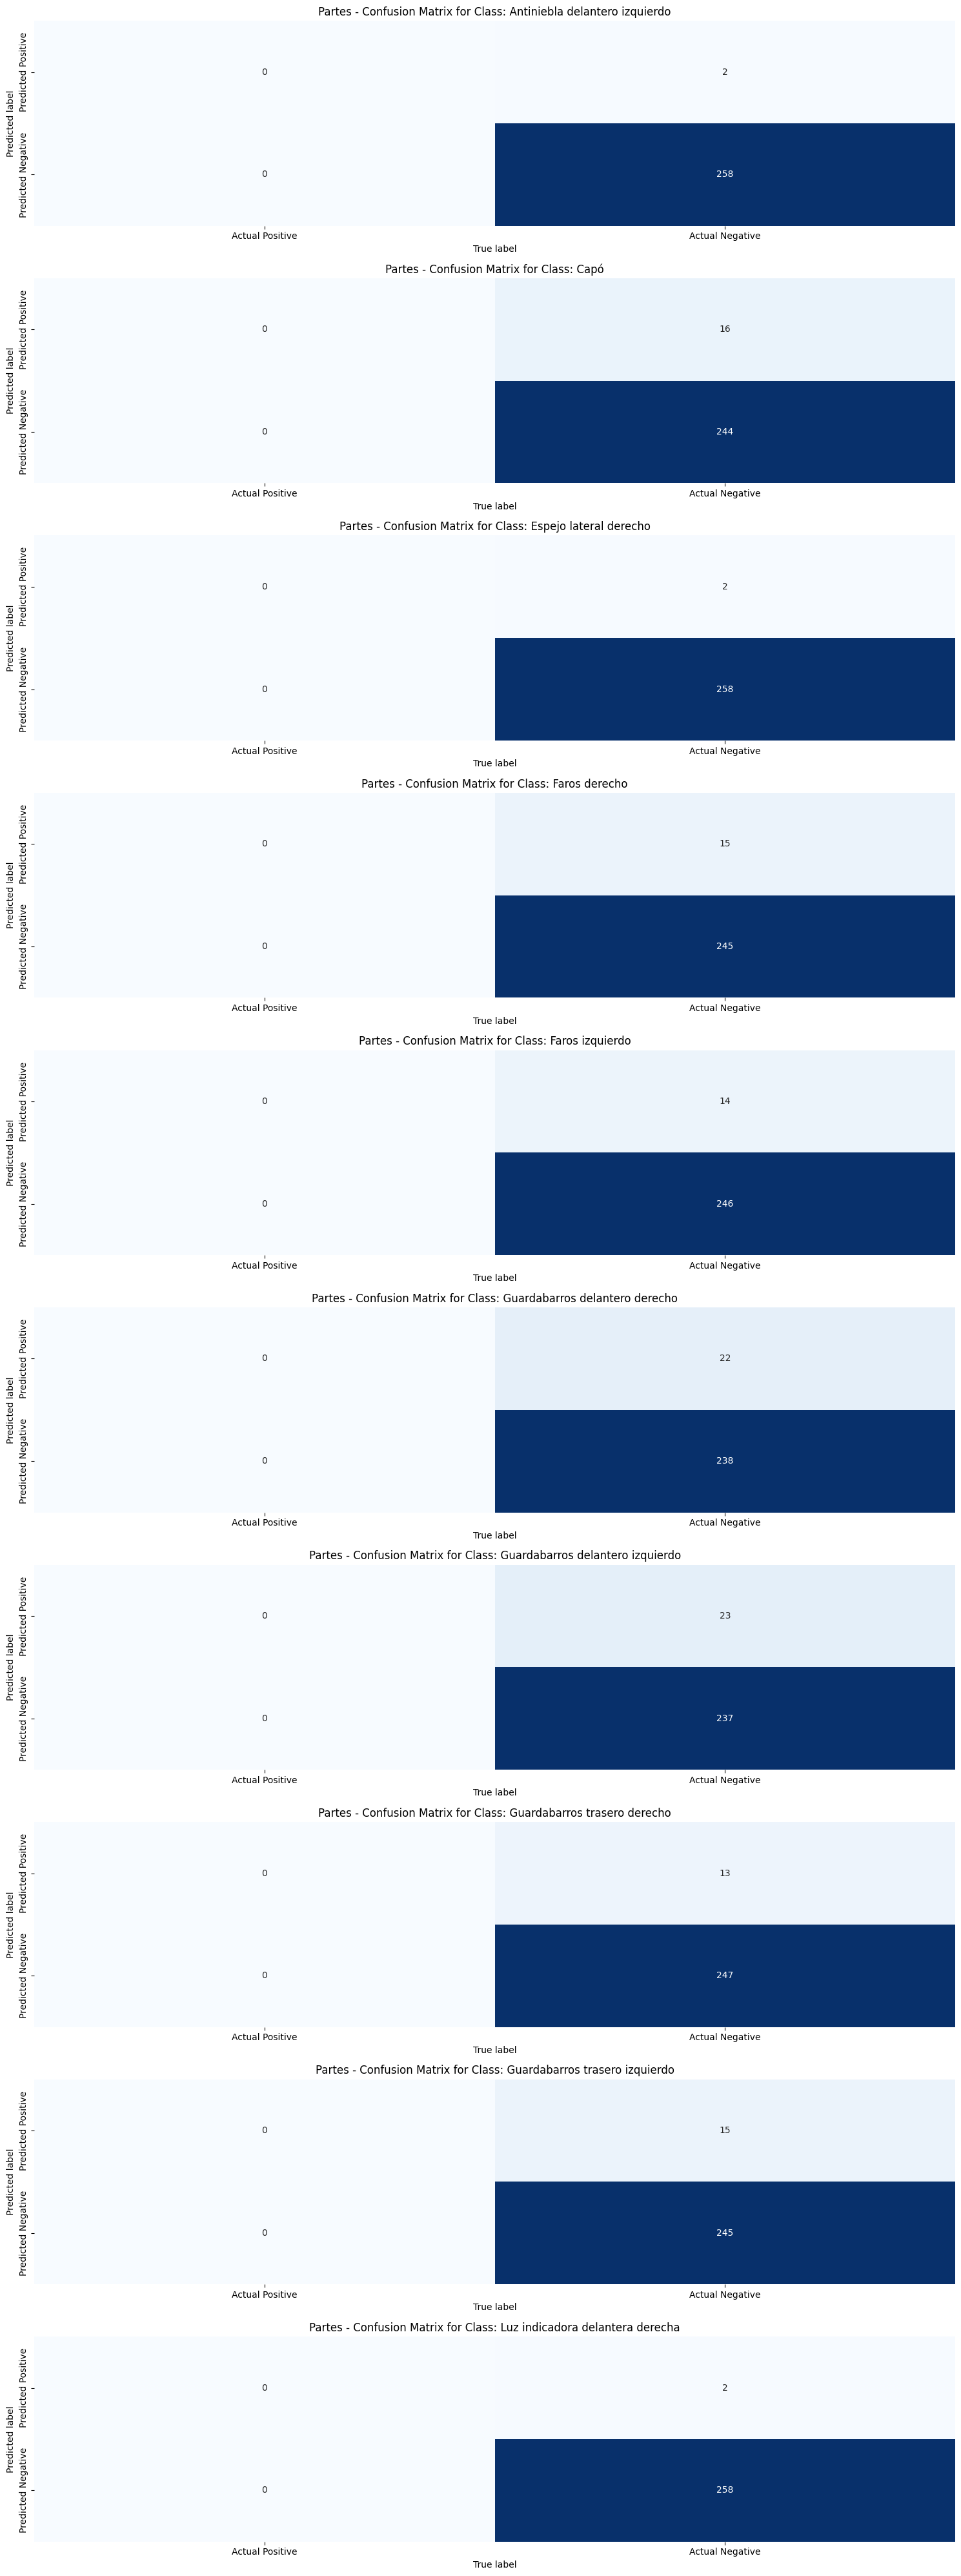

Plotting confusion matrices for Daños...


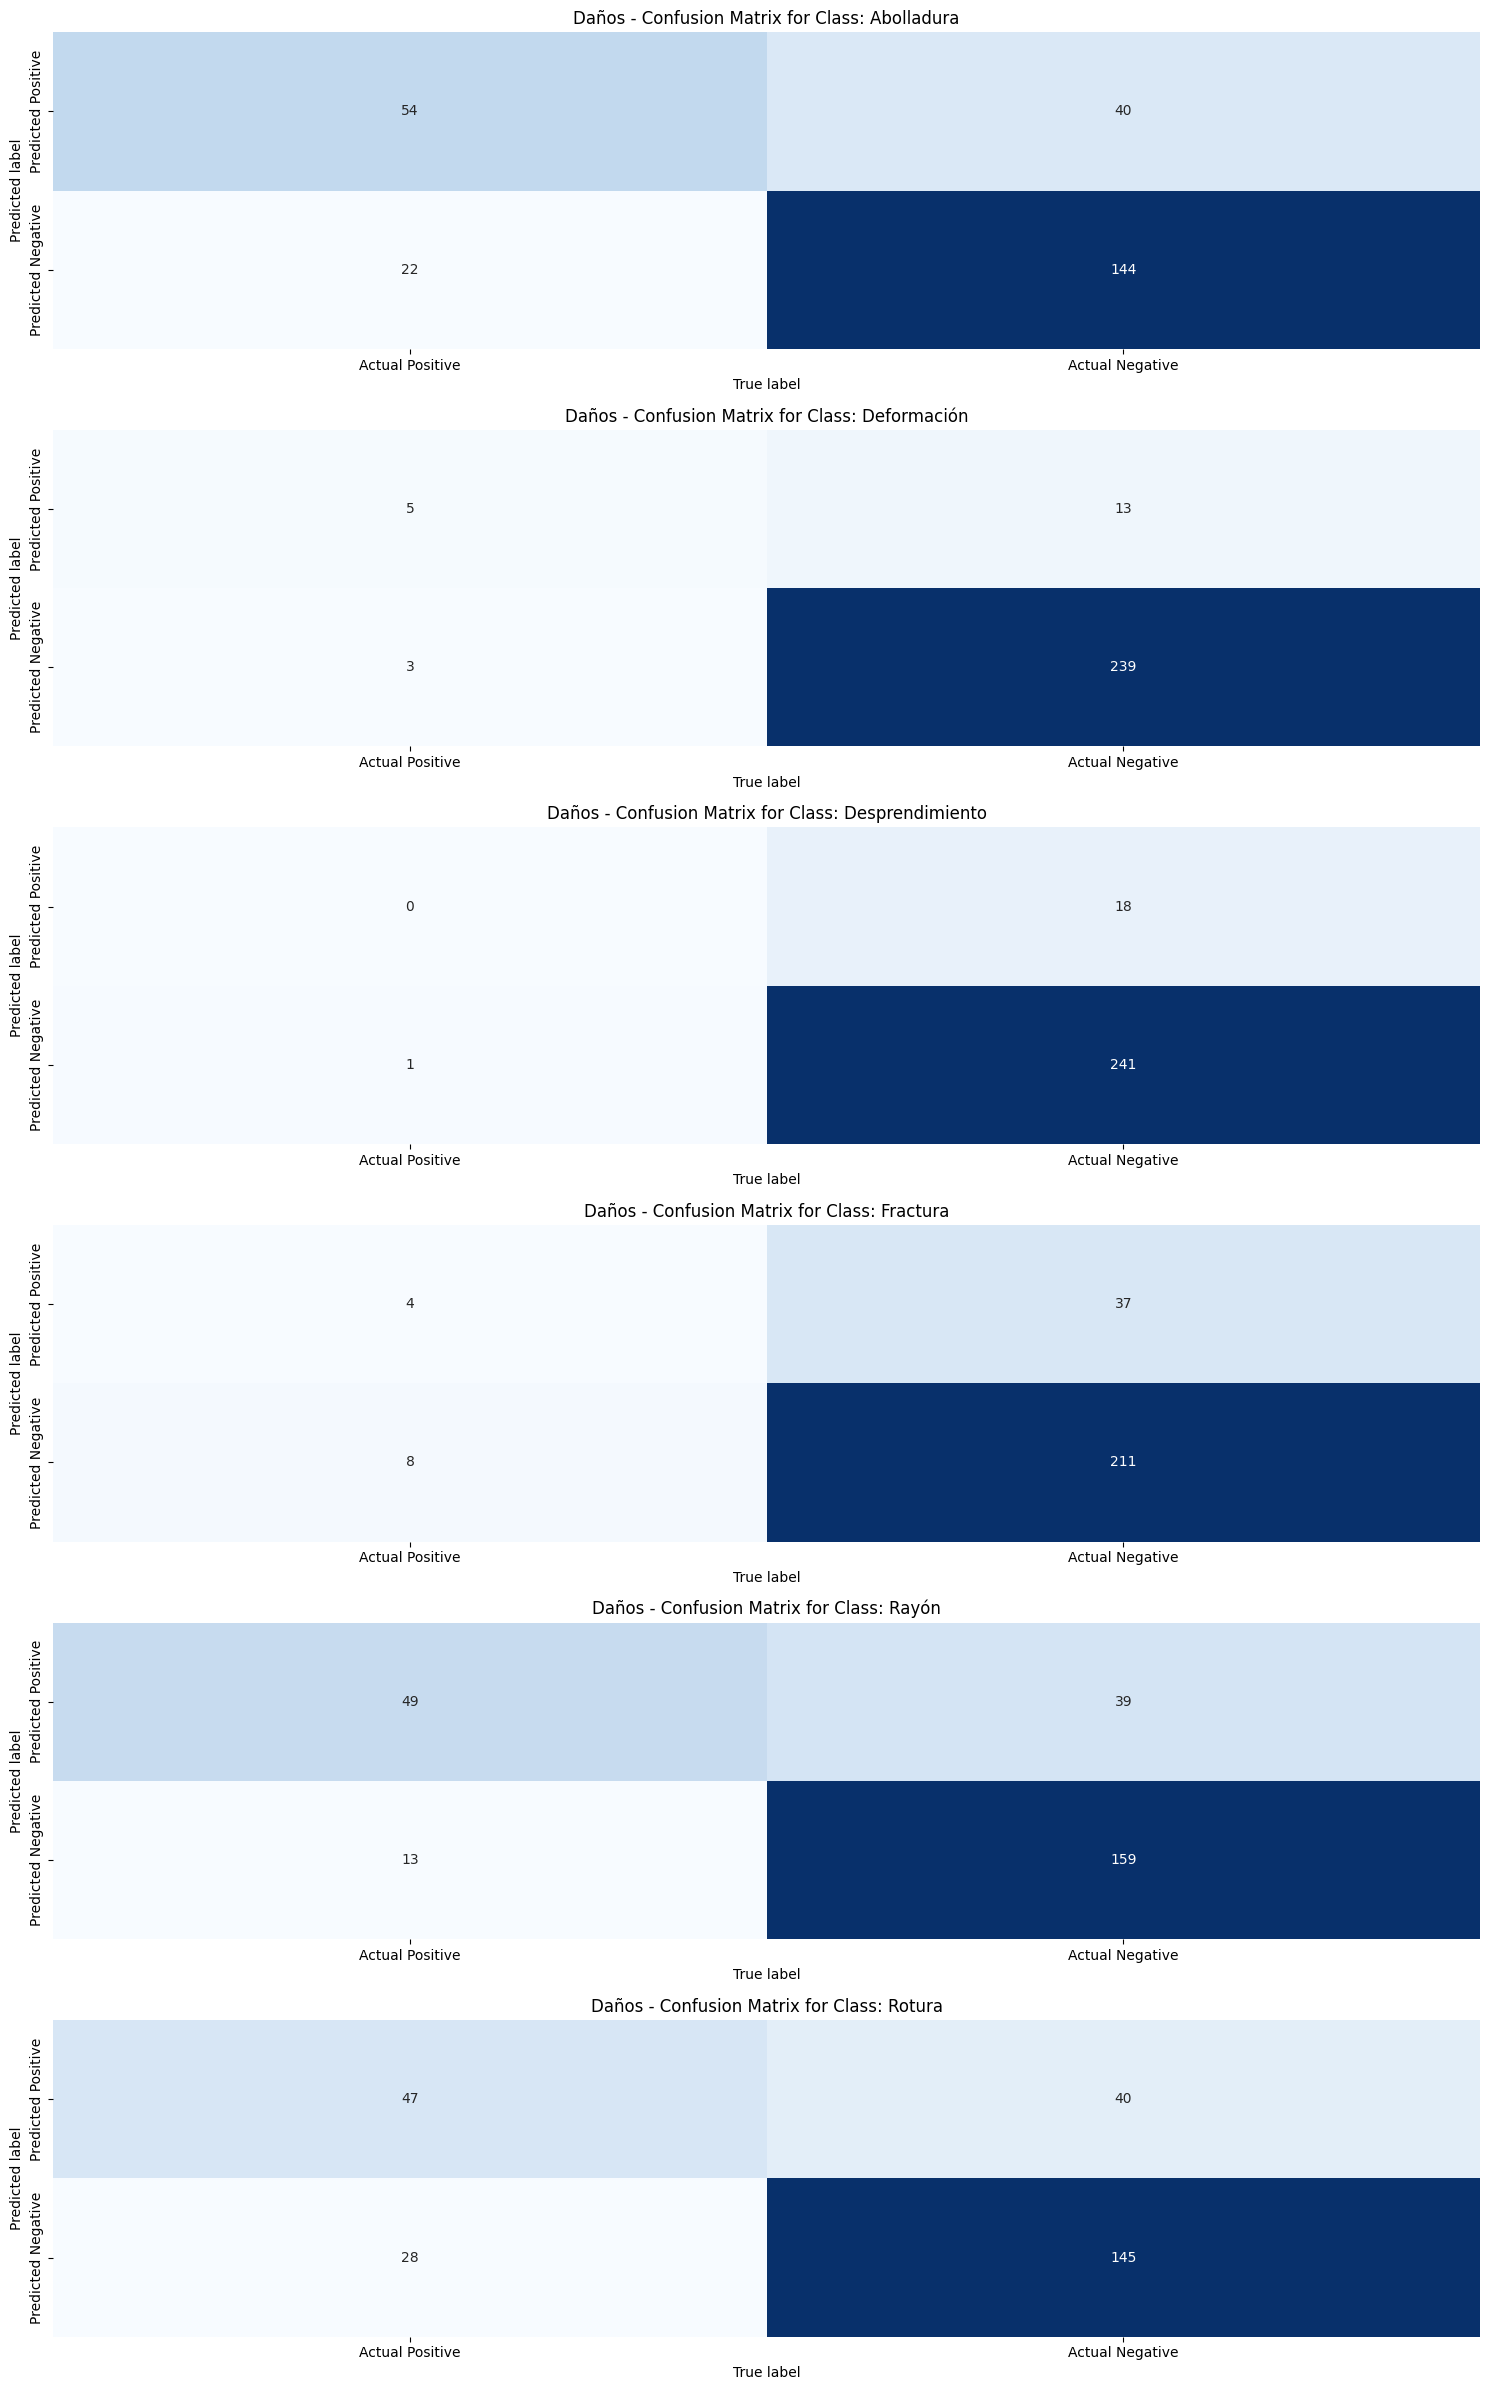

Plotting confusion matrices for Sugerencias...


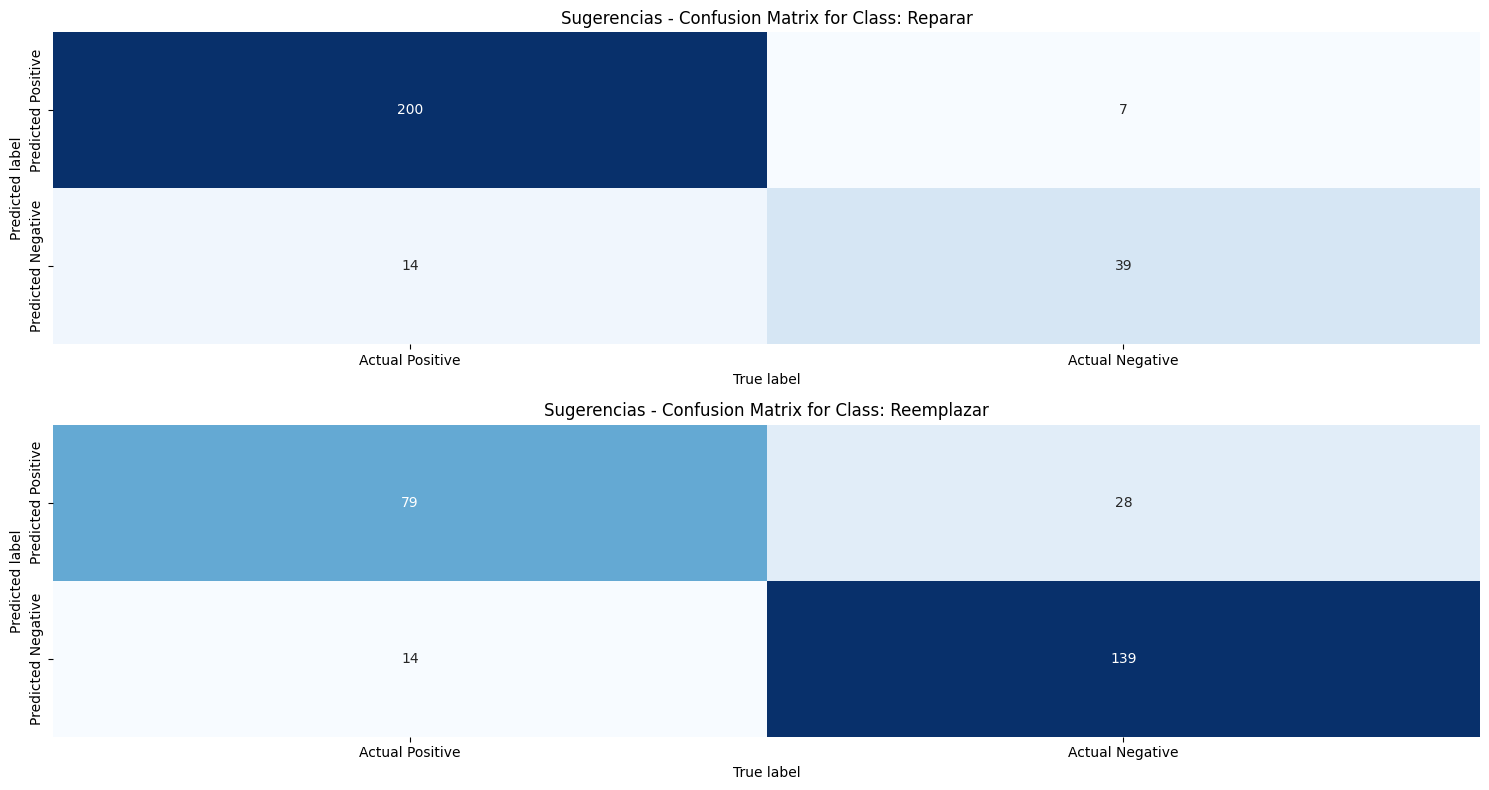

In [12]:
generate_confusion_matrices_by_task(
    evaluation_results,
    mlb_partes, mlb_dannos, mlb_sugerencias,
    label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias
)

---